# Step 5b: Modeling

## Modeling Process Workflow

Our modeling pipeline follows these steps:

1. **Data Preparation**
   - Load forecast panel data with 21 engineered features (from Step 4)
   - Split data: Train (2010-2023) / Test (2024+)
   - Create horizon targets (1-week ahead predictions)

2. **Feature Processing**
   - One-hot encode categorical features (drop first)
   - Pass through numerical features unchanged
   - All processing done via sklearn Pipeline to prevent data leakage

3. **Model Training** (4 separate models)
   - **Mean Model**: LightGBM with Poisson objective
   - **90th/50th/10th Percentile Models**: LightGBM with quantile objective
   - Each uses hyperparameters optimized in Step 5a via Optuna
   - Time-series cross-validation on training set (expanding window by year)

4. **Regularization** (Key for generalization)
   - L1 regularization (lambda_l1): Feature selection, removes noisy features
   - L2 regularization (lambda_l2): Shrinks extreme predictions, robust to outliers
   - Quantile models use 3-5x more regularization than mean model

5. **Evaluation**
   - Residual analysis (distribution, normality tests, skewness)
   - Performance metrics (MAE, RMSE, Poisson deviance)
   - Per-complaint-family analysis to identify strengths/weaknesses

6. **Model Persistence**
   - Save full bundle (model + metadata) for evaluation
   - Save just model for production deployment (Streamlit app)

---

## Overview: Modeling Approach

This notebook trains multi-quantile forecast models to predict NYC 311 service request volumes at the hex8-complaint_family-week level. We implement **4 separate LightGBM models** to capture different aspects of the demand distribution:

1. **Mean Model** (Poisson objective) - predicts expected volume
2. **90th Percentile Model** (quantile objective) - predicts high-demand scenarios
3. **50th Percentile Model** (quantile objective) - predicts median demand
4. **10th Percentile Model** (quantile objective) - predicts low-demand scenarios

### Why Multiple Models?

Service request volumes follow a count distribution with significant variance. A single point estimate (mean) doesn't capture:
- **Uncertainty** in the forecast
- **Planning for high-demand scenarios** (90th percentile for resource allocation)
- **Identifying quiet periods** (10th percentile for maintenance scheduling)

By modeling multiple quantiles, we provide actionable forecasts for different planning scenarios and provide a range which generally more understandable to a person.

---

### Why Poisson Objective for Mean Model?

Service request counts are naturally **non-negative integers** that follow a count distribution. The Poisson objective is ideal for this problem because:

1. **Count Data Distribution**: 
   - Poisson models the probability of observing k events (service requests) in a fixed interval

2. **Handling Zeros**:
   - Many hex-complaint_family-week combinations have 0 requests

#### Alternative Approaches Considered
- **Tweedie**: Good alternative but Poisson is simpler and performed well enough
---

### Features Used
Our models use **21 total features** divided into two categories:

#### Numerical Features (15 features)

| Feature Category      | Feature Name       | Description                                             |
|----------------------|-----------------|---------------------------------------------------------|
| Lag Features          | lag1            | Service requests from 1 week ago                        |
| Lag Features          | lag4            | Service requests from 4 weeks ago (captures monthly pattern) |
| Rolling Aggregates    | roll4           | Total requests over last 4 weeks (captures recent trend) |
| Rolling Aggregates    | roll12          | Total requests over last 12 weeks (captures longer-term baseline) |
| Rolling Aggregates    | momentum        | Ratio of roll4/roll12 (captures acceleration/deceleration) |
| Temporal Gaps         | weeks_since_last | Weeks since last request at this location             |
| Weather Features      | tavg            | Average temperature (°F)                                |
| Weather Features      | prcp            | Precipitation (inches)                                  |
| Weather Features      | heating_degree  | Heating degree days (65°F baseline)                     |
| Weather Features      | cooling_degree  | Cooling degree days (65°F baseline)                     |
| Weather Features      | rain_3d         | 3-day cumulative rainfall                                |
| Weather Features      | rain_7d         | 7-day cumulative rainfall                                |
| Neighborhood Features | log_pop         | Log population density at hex8 level                    |
| Neighborhood Features | nbr_roll4       | Sum of roll4 across neighboring hex7 parent            |
| Neighborhood Features | nbr_roll12      | Sum of roll12 across neighboring hex7 parent           |

#### Categorical Features (6 features)

| Feature Category | Feature Name       | Description                                           |
|-----------------|------------------|-------------------------------------------------------|
| Temporal        | month            | Month of year (1-12)                                  |
| Temporal        | heat_flag        | Binary indicator for extreme heat days               |
| Temporal        | freeze_flag      | Binary indicator for freeze days                     |
| Spatial         | hex6             | H3 hexagon at resolution 6 (~36km²) for geographic clustering |
| Spatial         | complaint_family | Type of service request (4 categories)               |
| Contextual      | covid_flag       | Pre/during/post COVID period indicator               |

#### Regularization: L1 and L2 for Feature Selection & Outlier Handling
Because we are predicting at a **granular level** and the number of features is limited, we initially provide the model with **all features** so it can explore potential interactions. To reduce overfitting, we apply **L1 and L2 regularization** during hyperparameter tuning in our Optuna runs:

- **L1 Regularization**: Encourages sparsity in the coefficients, effectively performing feature selection by shrinking some coefficients to zero.  
- **L2 Regularization**: Penalizes large coefficients, spreading the influence across correlated features and stabilizing the model.  

Together, these regularizations allow the model to **balance complexity and predictive performance** while minimizing overfitting.

---



## Import Packages


In [ ]:
import os
import sys

PACKAGE_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PACKAGE_PATH)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from datetime import datetime

from src import config
from src import forecast
from sklearn.metrics import mean_absolute_error

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
from importlib import reload

c:\Users\gorav\GitHub\nyc-311-service-requests\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
forecast_panel = pd.read_parquet(config.PRESENTATION_DATA_PATH + '/model_fitting_data.parquet')


## Inputs

In [ ]:
numerical_columns = config.NUMERICAL_COLUMNS
categorical_columns = config.CATEGORICAL_COLUMNS
horizons = [1]

### Fit Mean Models
Uncomment the below if you want to fit the model. It takes ~2 minutes.

In [4]:
# bundle_mean = forecast.train_models(
#     forecast_panel,
#     numerical_columns,
#     categorical_columns,
#     horizons,
#     'mean'
# )

### Fit 90th Percentile Models
Uncomment the below if you want to fit the model. It takes ~2 minutes.


In [42]:
# bundle_90 = forecast.train_models(
#     forecast_panel,
#     numerical_columns,
#     categorical_columns,
#     horizons,
#     '90'
# )

### Fit 50th Percentile Models
Uncomment the below if you want to fit the model. It takes ~2 minutes.


In [43]:
# bundle_50 = forecast.train_models(
#     forecast_panel,
#     numerical_columns,
#     categorical_columns,
#     horizons,
#     '50'
# )

### Fit 10th Percentile Models
Uncomment the below if you want to fit the model. It takes ~2 minutes.


In [45]:
# bundle_10 = forecast.train_models(
#     forecast_panel,
#     numerical_columns,
#     categorical_columns,
#     horizons,
#     '10'
# )

## Save All Bundles

This will save the bundles locally to `./data`. It will create **two versions** of each model: `full_bundle` and `just_model`. The `full_bundle` is required to run `evaluate_models`.

The `just_model` bundle is mainly used in the Streamlit app to score the data. We use this version so it **loads very quickly**.


In [8]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# forecast.save_bundle(bundle_mean,  timestamp, 'lgb_mean.pkl')
# forecast.save_bundle(bundle_90,  timestamp, 'lgb_90.pkl')
# forecast.save_bundle(bundle_50,  timestamp, 'lgb_50.pkl')
# forecast.save_bundle(bundle_10,  timestamp, 'lgb_10.pkl')

## Evaluate Models

We evaluate all four models on the train and test sets using multiple metrics and residual analysis.

**Metrics Used**

- **RMSE**: Penalizes large errors; shows the magnitude of prediction errors.
- **MAE**: Average absolute difference; interpretable in original units (service requests/week).
- **Poisson Deviance**: Measures fit for count data using the Poisson likelihood.

> Note: MAE was the primary metric reviewed.

**Residual Analysis**

For each model, we check:
- **Normality**: Shapiro-Wilk and Anderson-Darling tests.
- **Skewness/Kurtosis**: Assess tail behavior and symmetry.
- **Distribution shape**: Identify systematic bias or heteroskedasticity.

> Note: `forecast.evaluate_models` requires the full bundle in order to run.

**Model Results**

The model results are fairly consistent across the targets. The cross-validation score decreases as new data is introduced because the model isn’t adapting to ticket trends quickly enough. It would be interesting to explore how a rolling window model could perform (e.g., training on just the past three years versus the entire history).

The calibration plots for all models (except the 10th percentile) look very promising, with the model matching the average rates well.

Looking at performance between train and test, there don’t appear to be signs of overfitting, as the train and test metrics are largely in parity.

Residuals are interesting to observe. It’s clear from the QQ plot that we aren’t able to model the tails very well, which means our quantile results are likely not wide enough.

The residuals vs. fitted plot was initially very perplexing but can be explained by the objective function we are using. We are using a standard Poisson distribution that starts at 0, but our training data does not. Every time the model predicts 0, the residual equals the actual value, hence the linear negative slope in the plot. This was something I didn't have enough time to explore, but I assume would resolve the problem.


In [9]:
timestamp = config.MODEL_TIMESTAMP
timestamp

'20251006_154213'

In [10]:
# Takes 2 Minutes
bundle_mean = forecast.load_bundle_s3(timestamp, 'lgb_mean.pkl', 'full_bundle')
bundle_90 = forecast.load_bundle_s3(timestamp, 'lgb_90.pkl', 'full_bundle')
bundle_50 = forecast.load_bundle_s3(timestamp, 'lgb_50.pkl', 'full_bundle')
bundle_10 = forecast.load_bundle_s3(timestamp, 'lgb_10.pkl', 'full_bundle')

Model bundle loaded from: s3://hbc-technical-assessment-gk/models/20251006_154213/full_bundle/lgb_mean.pkl
Model bundle loaded from: s3://hbc-technical-assessment-gk/models/20251006_154213/full_bundle/lgb_90.pkl
Model bundle loaded from: s3://hbc-technical-assessment-gk/models/20251006_154213/full_bundle/lgb_50.pkl
Model bundle loaded from: s3://hbc-technical-assessment-gk/models/20251006_154213/full_bundle/lgb_10.pkl


### Evaluate Mean Models
CV Score: 
Calibration Chart
Residuals:
Metrics:



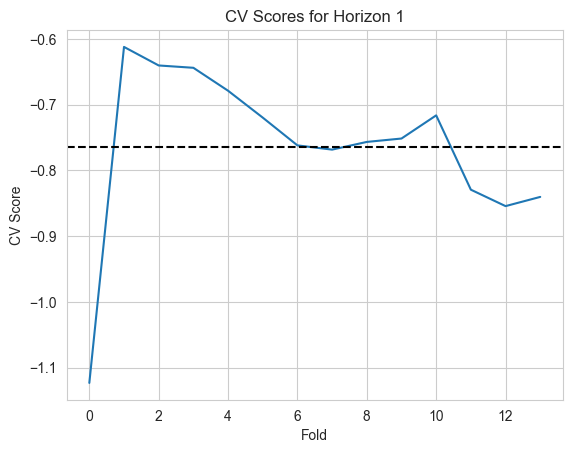

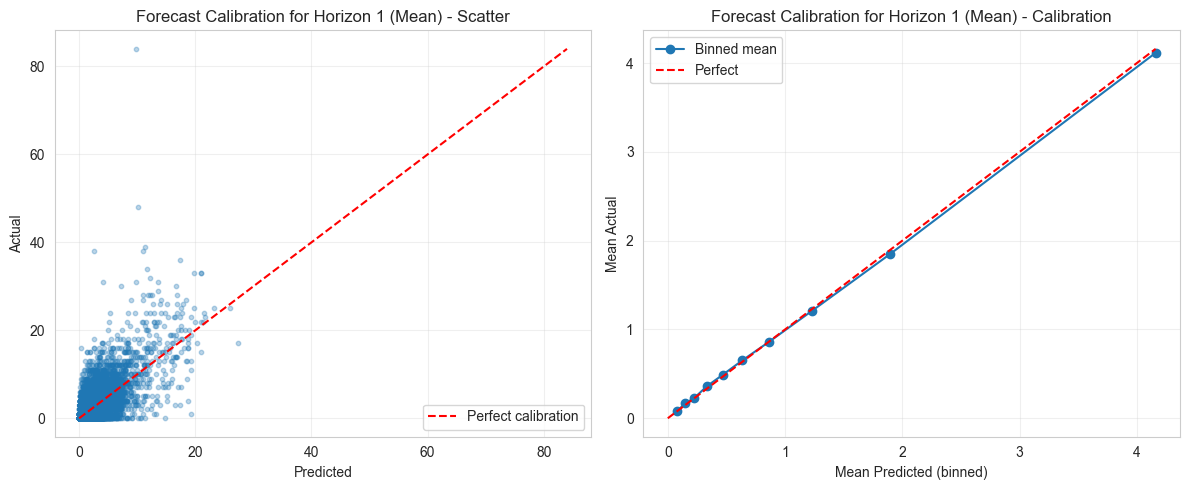

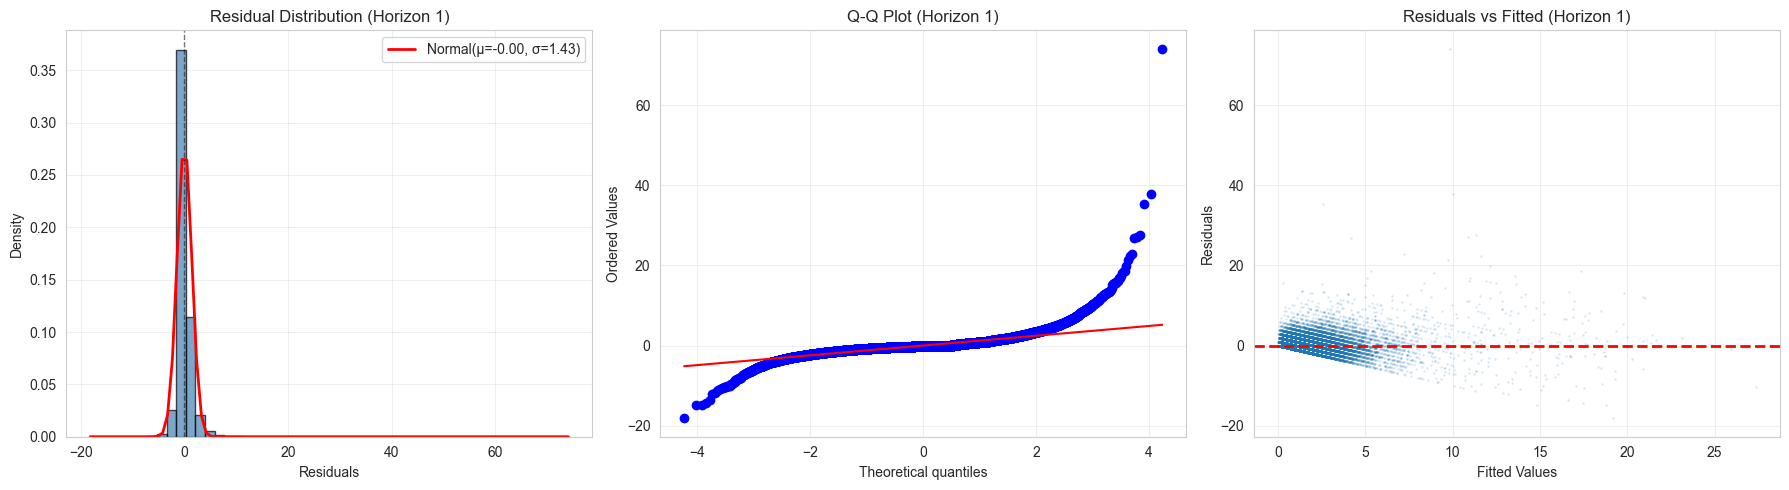


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: -0.0024
  Std Dev: 1.4295
  Median: -0.1808
  Skewness: 5.0949
  Kurtosis: 159.7793

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.7839
  P-value: 4.6406e-63
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 3527.1326
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.1584583863459479, 'mae': 0.7256516337822149, 'poisson_deviance': 1.099705866088741, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 1.4295095422968525, 'mae': 0.8196896237827317, 'poisson_deviance': 1.2464631637502626, 'n_samples': 60374}}



In [11]:
reload(forecast)
forecast.evaluate_models(bundle_mean, model_type = 'mean')

### Evaluate 90th Percentile Models

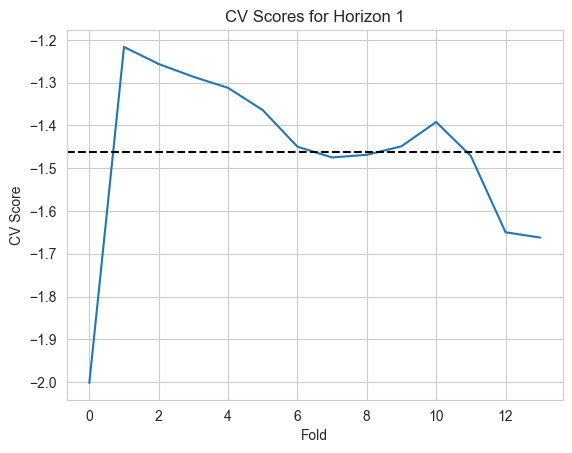

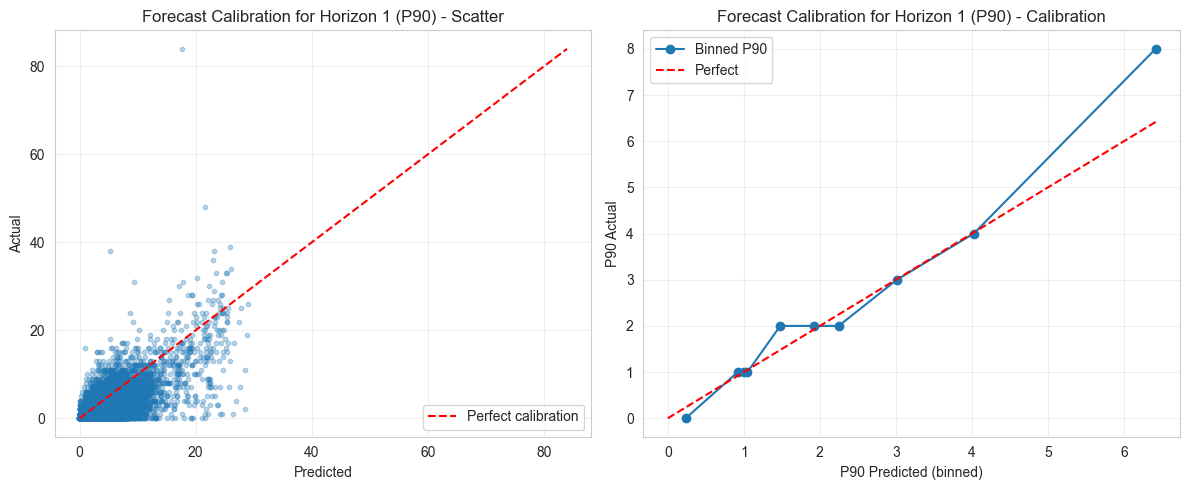

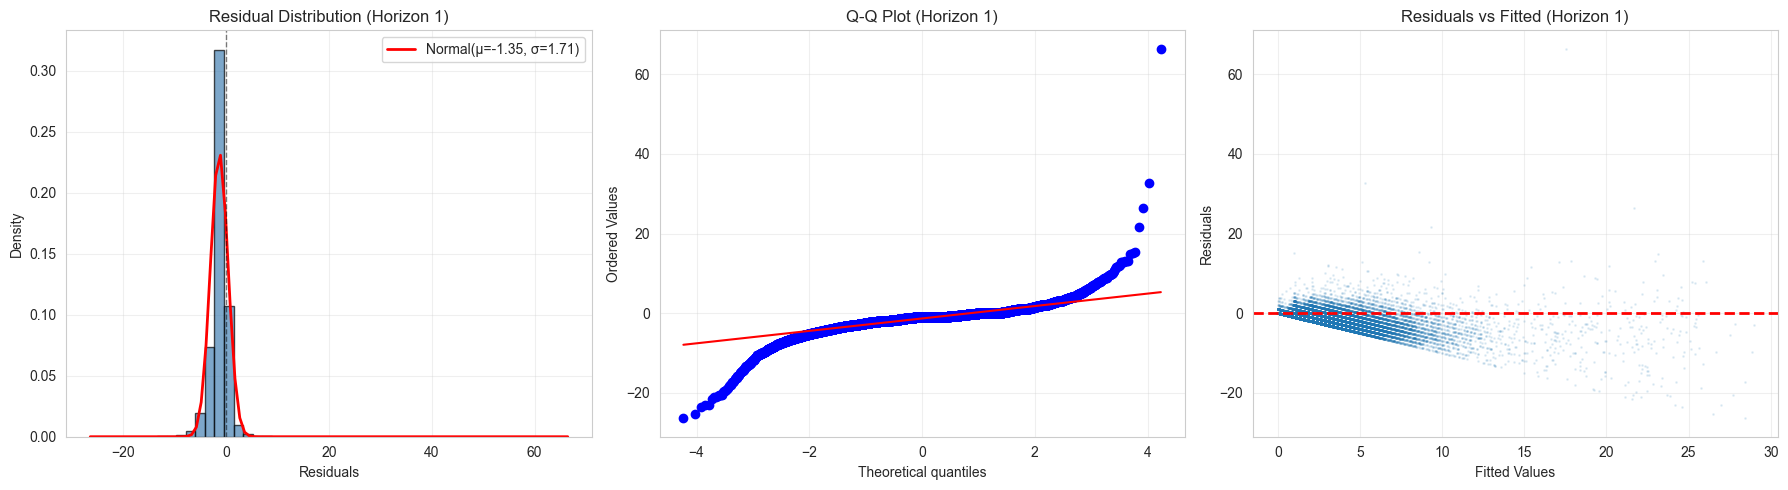


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: -1.3518
  Std Dev: 1.7125
  Median: -1.0229
  Skewness: -0.0697
  Kurtosis: 59.0365

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.8756
  P-value: 5.9897e-53
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 1980.0488
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.9058719235745105, 'mae': 1.4513612379249703, 'poisson_deviance': 2.1675191776143388, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 2.1817414895651854, 'mae': 1.576305009424253, 'poisson_deviance': 2.3217836482125747, 'n_samples': 60374}}



In [12]:
reload(forecast)
forecast.evaluate_models(bundle_90, model_type = '90')

### Evaluate 50th Percentile Models

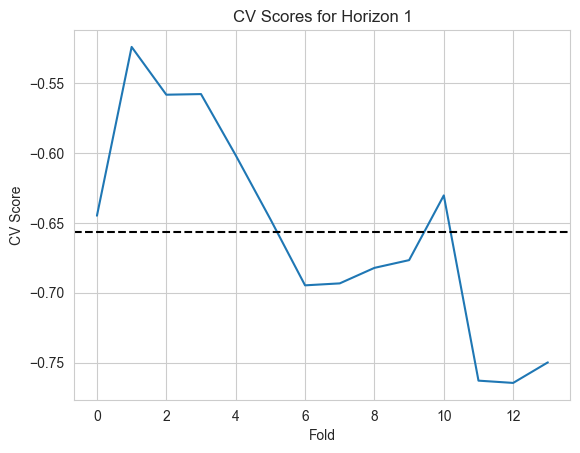

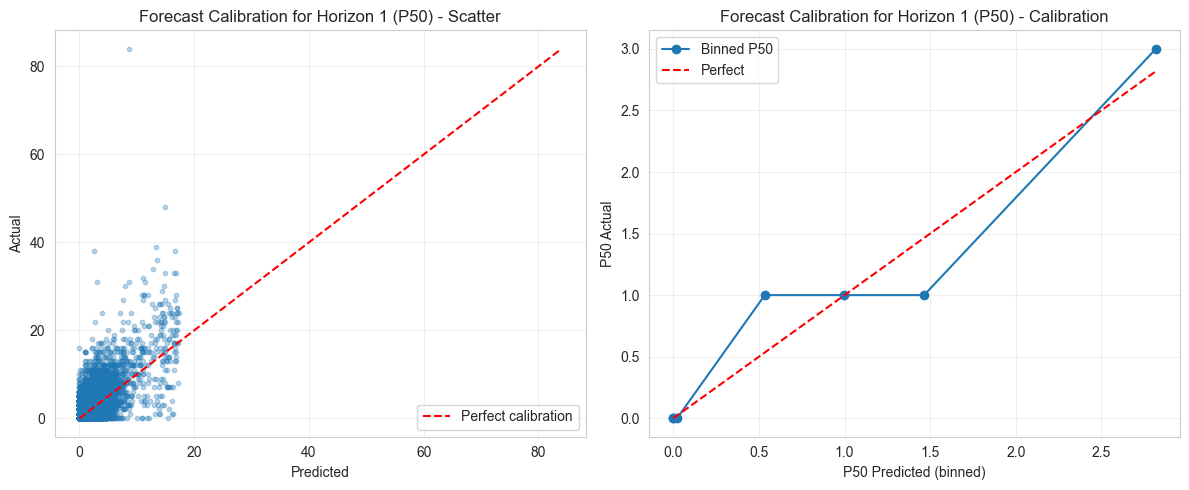

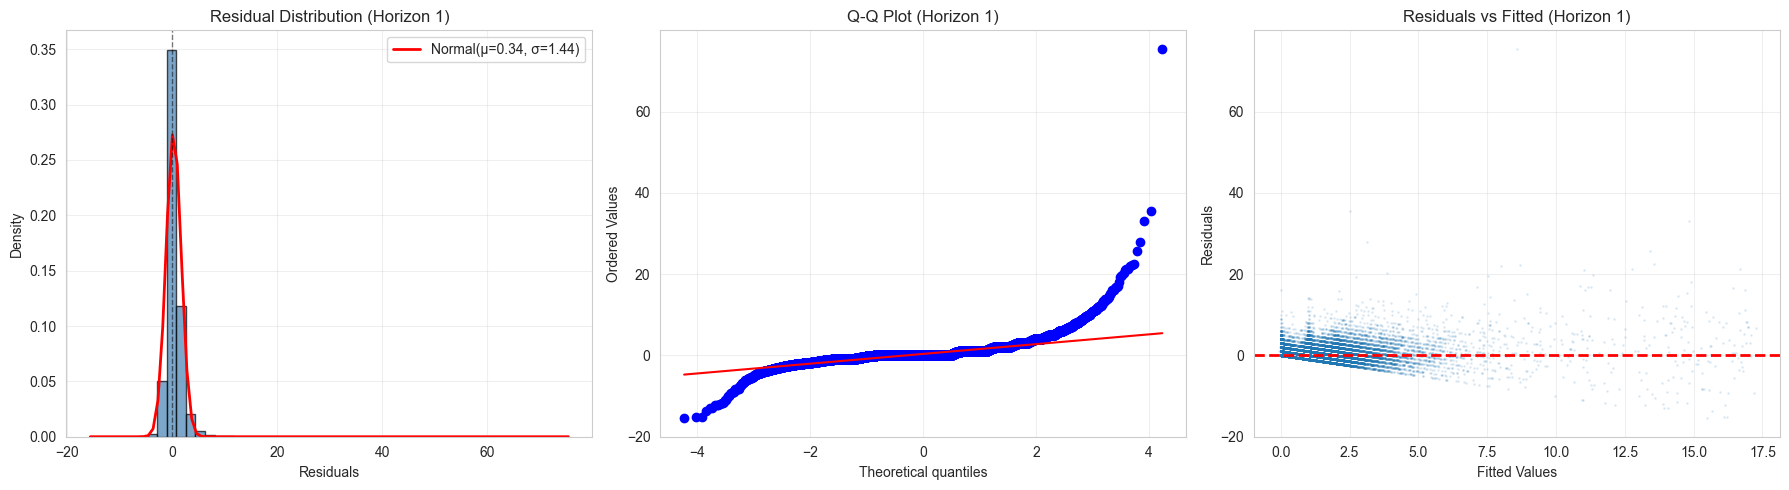


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.3416
  Std Dev: 1.4450
  Median: 0.0000
  Skewness: 5.1554
  Kurtosis: 155.6399

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.7135
  P-value: 1.4396e-68
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 5050.2626
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.246844313213766, 'mae': 0.6466420541725157, 'poisson_deviance': 6.847640219899114, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 1.4848077641039132, 'mae': 0.7332055327644321, 'poisson_deviance': 7.048815525235706, 'n_samples': 60374}}



In [13]:
reload(forecast)
forecast.evaluate_models(bundle_50, model_type = '50')

### Evaluate 10th Percentile Models

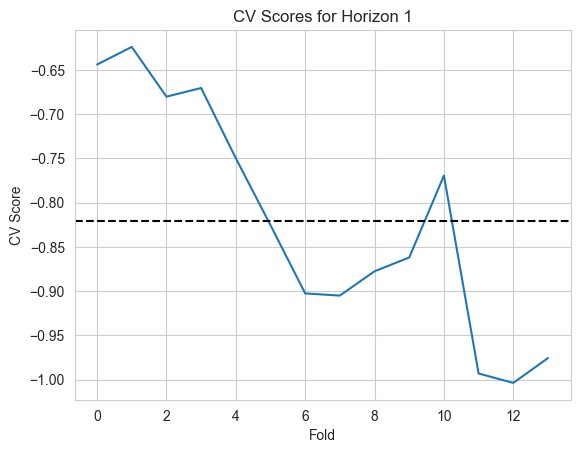

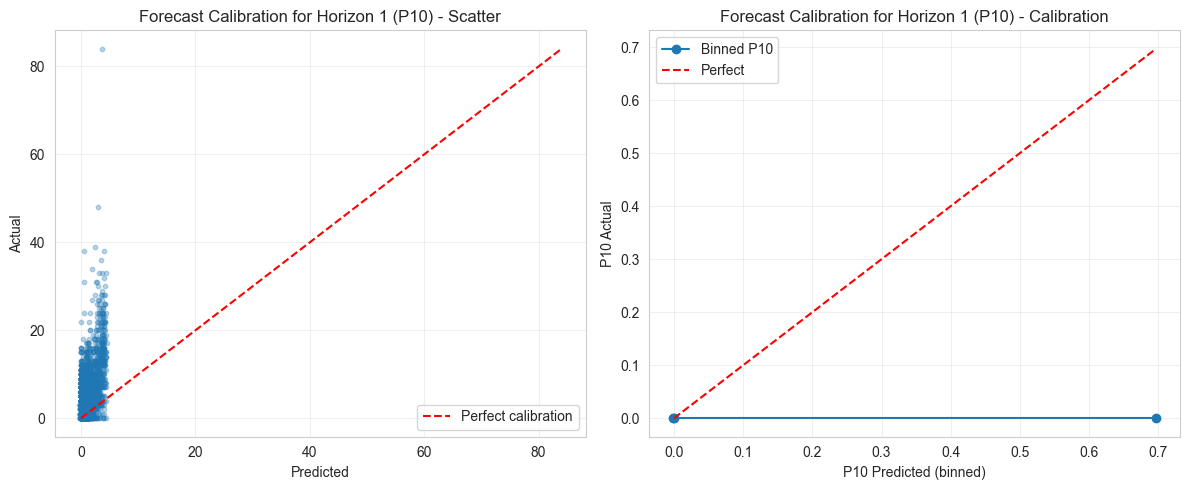

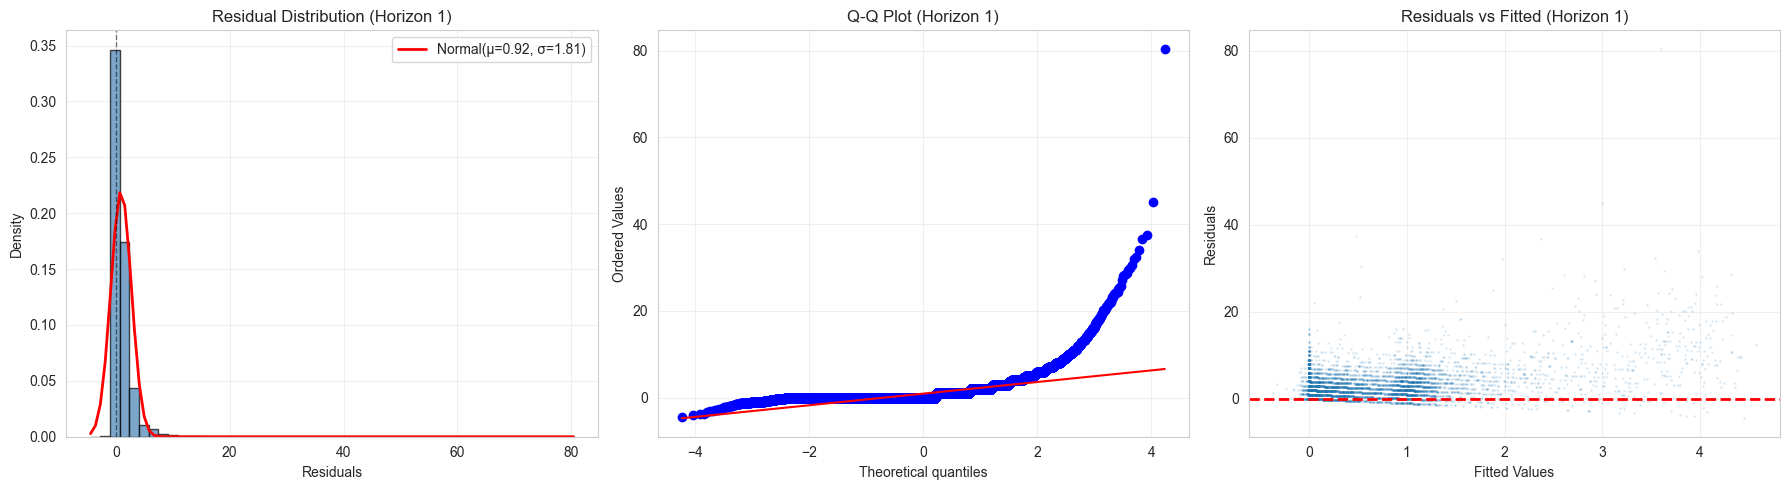


Horizon 1 - Residual Analysis
Residual Statistics:
  Mean: 0.9182
  Std Dev: 1.8134
  Median: 0.0000
  Skewness: 6.1171
  Kurtosis: 107.2500

Shapiro-Wilk Normality Test (n=5000):
  Statistic: 0.5588
  P-value: 1.8223e-77
  Interpretation: Residuals are NOT normally distributed (α=0.05)

Anderson-Darling Normality Test:
  Statistic: 7661.1556
  Critical Values: [0.576 0.656 0.787 0.918 1.092]
  Significance Levels: [15.  10.   5.   2.5  1. ]%

------------------------------------------------------------
Model Performance Metrics:
{'train': {'horizon': 1, 'rmse': 1.6869617843384026, 'mae': 0.8285948709595505, 'poisson_deviance': 26.426714675319, 'n_samples': 487161}, 'test': {'horizon': 1, 'rmse': 2.0326410363805802, 'mae': 0.9307042391139765, 'poisson_deviance': 27.257695994960162, 'n_samples': 60374}}



In [14]:
reload(forecast)
forecast.evaluate_models(bundle_10, model_type = '10')

### Performance by Complaint Family

Looking at the table above, we can draw several insights:

Overall Generalization Quality
- **60-70% of complaint families** show worse test performance than train
- Some families show better test performance
- No severe overfitting observed

**Easiest to Predict** (consistently low MAE across models):
- Likely families with stable, predictable patterns
- Strong seasonal or weather correlation
- Consistent geographic concentration

**Hardest to Predict** (high MAE):
- Sporadic, event-driven requests
- Complaint families that have few records


In [57]:
df_eval = forecast_panel.copy()
df_eval['split'] = np.where(pd.to_datetime(df_eval['week']) >= '2024-01-01', 'test', 'train')

# Generate predictions for each model
df_eval["pred_mean"] = (bundle_mean['models'][1].predict(df_eval[config.NUMERICAL_COLUMNS + config.CATEGORICAL_COLUMNS]).round(0))
df_eval["pred_90"] = (bundle_90['models'][1].predict(df_eval[config.NUMERICAL_COLUMNS + config.CATEGORICAL_COLUMNS]).round(0))
df_eval["pred_50"] = (bundle_50['models'][1].predict(df_eval[config.NUMERICAL_COLUMNS + config.CATEGORICAL_COLUMNS]).round(0))
df_eval["pred_10"] = (bundle_10['models'][1].predict(df_eval[config.NUMERICAL_COLUMNS + config.CATEGORICAL_COLUMNS]).round(0))


mae_results = []
for complaint_type in df_eval['complaint_family'].unique():
    df_type = df_eval[df_eval['complaint_family'] == complaint_type]
    
    for split in ['train', 'test']:
        df_split = df_type[df_type['split'] == split]
        
        if len(df_split) > 0:
            mae_mean = mean_absolute_error(df_split['y'], df_split['pred_mean'])
            mae_90 = mean_absolute_error(df_split['y'], df_split['pred_90'])
            mae_50 = mean_absolute_error(df_split['y'], df_split['pred_50'])
            mae_10 = mean_absolute_error(df_split['y'], df_split['pred_10'])
            
            mae_results.append({
                'complaint_family': complaint_type,
                'split': split,
                'mae_mean': mae_mean,
                'mae_90': mae_90,
                'mae_50': mae_50,
                'mae_10': mae_10,
                'n_samples': len(df_split)
            })

df_mae = pd.DataFrame(mae_results)


display(df_mae)
df_mae = df_mae.pivot(index='complaint_family', columns='split', values=['mae_mean', 'mae_90', 'mae_50', 'mae_10']).round(2)
for metric in ['mae_mean', 'mae_90', 'mae_50', 'mae_10']:
    test_worse_fraction = (df_mae[metric]['test'] >= df_mae[metric]['train']).mean()
    print(f"Metric: {metric}")
    print(f"Percentage of times Test MAE is worse than Train: {test_worse_fraction:.2%}")
    print("-" * 70)

,complaint_family,split,mae_mean,mae_90,mae_50,mae_10,n_samples
0,animal_control,train,1.117996,0.324848,1.145182,1.174323,40425
1,animal_control,test,1.124293,0.335534,1.169370,1.193889,5302
2,vector_control,train,0.948746,1.221562,1.199966,1.850773,219397
3,vector_control,test,0.999364,1.362512,1.254131,1.976612,23602
4,water_quality,train,1.036364,0.914412,1.036807,1.037251,2255
5,water_quality,test,1.089686,0.838565,1.089686,1.089686,446
6,air_smoke_mold,train,0.969687,0.561661,1.163044,1.364175,80659
7,air_smoke_mold,test,0.942110,0.699163,1.182210,1.472694,11591
8,childcare_recreation,train,1.101350,0.772338,1.114849,1.138526,9334
9,childcare_recreation,test,1.136405,0.627371,1.153568,1.172538,2214


Metric: mae_mean
Percentage of times Test MAE is worse than Train: 70.00%
----------------------------------------------------------------------
Metric: mae_90
Percentage of times Test MAE is worse than Train: 60.00%
----------------------------------------------------------------------
Metric: mae_50
Percentage of times Test MAE is worse than Train: 70.00%
----------------------------------------------------------------------
Metric: mae_10
Percentage of times Test MAE is worse than Train: 70.00%
----------------------------------------------------------------------


## Conclusion

### What We Accomplished

We successfully trained **4 probabilistic forecast models** that provide uncertainty-aware predictions for NYC 311 service requests:

- **Mean Model**: Best overall point estimate (MAE 0.82)  
- **50th Percentile**: Lowest error (MAE 0.73), most reliable for typical planning  
- **90th Percentile**: Excellent high-demand forecasts (9% test degradation)  
- **10th Percentile**: Identified area of improvement... for modeling

### Areas of Improvement

**Models**  
- Explore Tweedie objective to better handle outliers.  
- Try truncated Poisson.
- Expand to future horizons (less useful for immediate allocation but helpful for long-term planning and headcount decisions).  
- Extend to other agencies.
- Incorporate severity, triage, and duration to recommend zones to prioritize, beyond just projecting demand.  
  - Include Rodent Inspections dataset for more impactful features.

**Streamlit Application**  
- Add forecast scenarios: allow users to enter inputs for weather and demand assumptions to see adjusted estimates.  
- Make the map interactive: enable zooming into hex areas and add hovertext showing longitude, latitude, and other relevant hex information.  
